# Exercise 6

Group Members: Luis Pazos Clemens, Robert Freund, Eugen Dizer

Deadline: 05.02.2021, 16:00.

In [67]:
#Load standard libraries
import numpy as np   
import matplotlib.pyplot as plt  
from scipy.sparse import coo_matrix
from scipy.sparse import csc_matrix
from scipy.sparse import linalg

## 3. Denoising of a CT image

In [68]:
def construct_X(M,alphas,Np,tau=0):
    
    '''
        M: integer; number of the pixels in one direction
        alphas: np.array of the angles
        Np: integer; number of pixels of the detector
    '''
    
    alphas = alphas*2*np.pi/360 #translation from grad into rad
    N0 = len(alphas) #number of angles
    #produce meshgrid
    c = np.mgrid[-M/2+0.5:M/2,-M/2+0.5:M/2]
    c[:] = -c[0],c[1] # numeration of the pixels starting from top left (0th pixel at top left)
    C1 = np.reshape(c,(2,M**2)) #get x and y coordinate of each pixel
    #several meshgrids for different angles
    C = np.zeros((N0,2,M**2))
    C[:] = C1
    
    #normal vector n and distance s0 between middle of sensor and position of 0th sensor
    n = np.array([np.sin(alphas),np.cos(alphas)])
    s0 = np.sqrt(2)*(M/2-0.5)
    
    #position where beam through this pixel hits the sensor for different angels
    p = np.multiply(C[:,0,:].T,n[0]).T+np.multiply(C[:,1,:].T,n[1]).T+s0
    
    #step between the sensors
    step = 2*s0/(Np-1)
    
    #divide the position into the sensor districts
    detect = p/step
    
    # which detector is the lower/upper one hit by the beam
    detect_indices_low = detect-detect%1
    detect_indices_up = detect_indices_low + 1
    #write into one array
    detect_indices = np.concatenate((detect_indices_low,detect_indices_up),axis=1)
    
    #calculate the index i with different angles (index i0)
    for i0 in range(N0):
        detect_indices[i0,:] = detect_indices[i0,:] + Np*i0
    
    #calulate the weight for each pixel and put them into the data array
    weight_2 = detect%1
    weight_1 = 1-detect%1
    data = np.concatenate((weight_1,weight_2),axis=1).flatten()
    
    #define indices i and j only where the weight is larger than zero
    i_indices = detect_indices.flatten()[data!=0]
    
    #define j_indices with the corresponding structure we used above for the
    # weight (called data) and the i_indices
    j_indices = np.zeros((N0,2,M**2))
    j_indices[:,:] = np.arange(M**2)
    j_indices = j_indices.flatten()[data!=0]
    
    #restrict data to data!=0
    data = data[data!=0]
    
    X = coo_matrix((data, (i_indices, j_indices)), shape=(Np*N0,M**2))
    
    #if tau is larger than zero add diagonal matrix below the original matrix
    if tau > 0:
        tau_data = np.full(M**2,np.sqrt(tau))
        data = np.concatenate((data,tau_data))
        tau_j = np.arange(M**2)
        j_indices = np.concatenate((j_indices,tau_j))
        tau_i = np.arange(M**2)+Np*N0
        i_indices = np.concatenate((i_indices,tau_i))
        X = coo_matrix((data, (i_indices, j_indices)), shape=(Np*N0+M**2,M**2))
    
    return X

In [69]:
#load M=195 data
Np = 275
M = 195

alphas_195=np.load('hs_tomography/alphas_195.npy')
y_195 = np.load('hs_tomography/y_195.npy')

In [70]:
#clean data to get 60 projection angles
index = [int(np.ceil(len(alphas_195) * p/64)) for p in range(64)]
alphas_195_64 = alphas_195[index]

y_195_64 = []

for j in index:
    y_195_64.extend(y_195[j*Np : (j+1)*Np])

y_195_64_tau = np.concatenate((y_195_64,np.zeros(M**2)))


Text(0.5, 1.0, 'tau = 0')

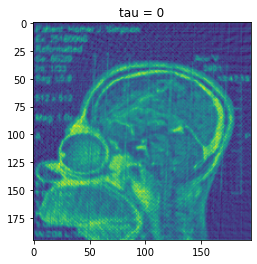

In [86]:
#plot tau=0
tol = 10**(-3)

X_195 = construct_X(195,np.array(alphas_195_64),275)
X_195 = X_195.tocsc()
beta_195 = linalg.lsqr(X_195,y_195_64,atol = tol, btol=tol)
beta_195_matrix = np.reshape(beta_195[0],(195,195))
plt.imshow(beta_195_matrix)
plt.title("tau = 0")

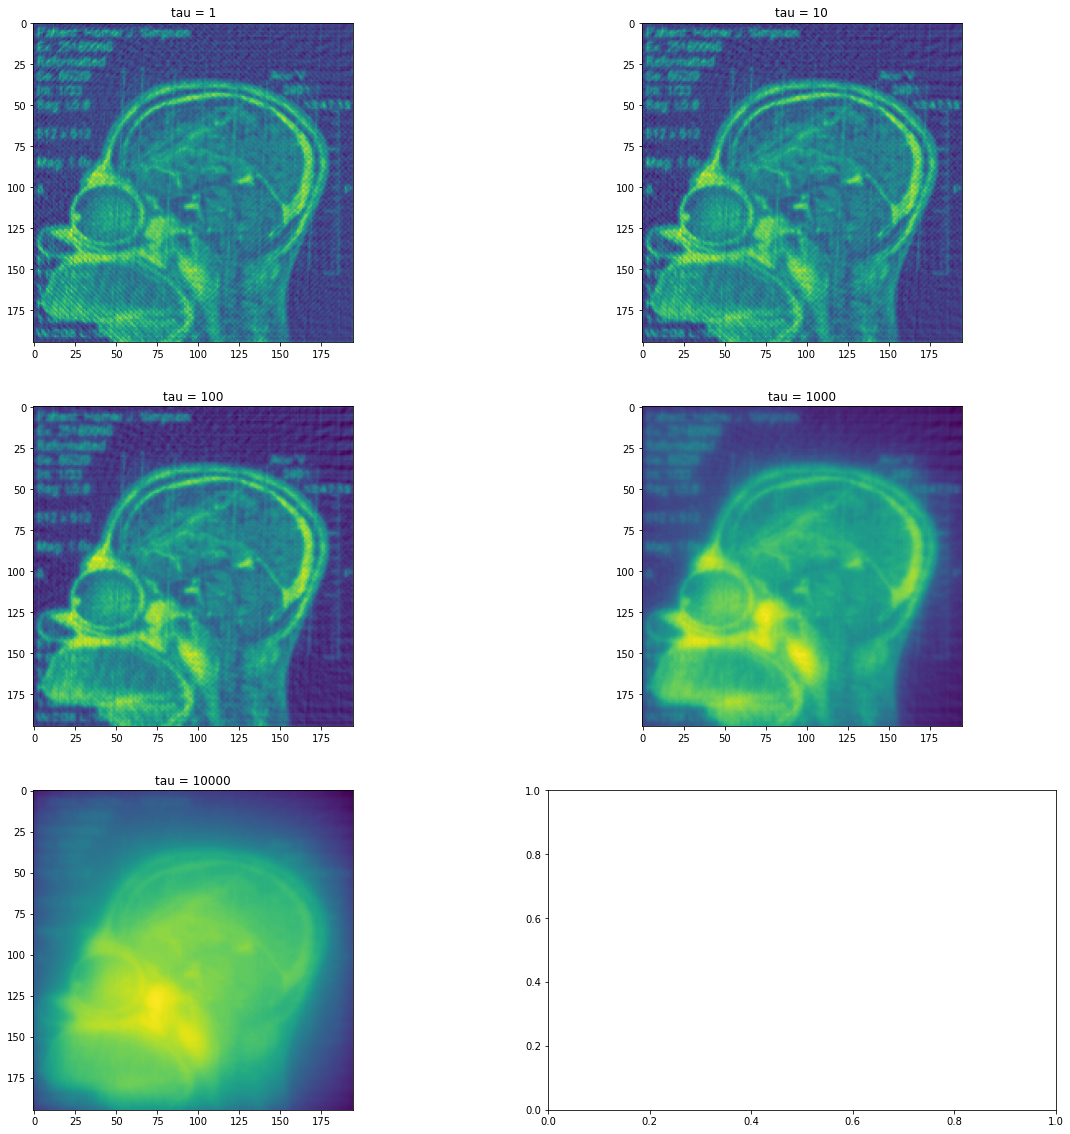

In [85]:
#plot tau = [1,10,100,1000,10000]

tau = [1,10,100,1000,10000]
fig, axs = plt.subplots(3,2,figsize=(20,20))

for i in range(len(tau)):
    X_195 = construct_X(195,np.array(alphas_195_64),275,tau[i])
    X_195 = X_195.tocsc()
    beta_195 = linalg.lsqr(X_195,y_195_64_tau,atol = tol, btol=tol)
    beta_195_matrix = np.reshape(beta_195[0],(195,195))
    axs[int(i/2),i%2].imshow(beta_195_matrix)
    axs[int(i/2),i%2].set_title("tau = {}".format(tau[i]))

The original and the first two pictures (tau = 1,10) look pretty similiar. So the quality gets only worse from my point of view. Maybe the reason is that the original photo has already fewer pixels than the detector, so the quality can not get better.